In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [24]:
#With discharge
file_path = r'U:\02_Software\Github\lstm_backward\results\with_discharge\y_obs.csv'
y_obs = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_obs.set_index(y_obs.columns[0],inplace=True)
file_path = r'U:\02_Software\Github\lstm_backward\results\with_discharge\y_sim.csv'
y_sim = pd.read_csv(file_path, parse_dates=[0])
file_path = r'U:\02_Software\Github\lstm_backward\results\with_discharge\NSE.csv'
nse_disch = pd.read_csv(file_path)
# Set the unnamed first column (dates) as the index
y_sim.set_index(y_sim.columns[0],inplace=True)
file_path = r'U:\02_Software\Github\lstm_backward\results\without_discharge\y_sim.csv'
y_sim_no_disch = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_sim_no_disch.set_index(y_sim_no_disch.columns[0],inplace=True)
file_path = r'U:\02_Software\Github\lstm_backward\results\without_discharge\NSE.csv'
nse_without_disch = pd.read_csv(file_path)

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Function to calculate precipitation indices for a single catchment
def calculate_precipitation_indices(series):
    # Initialize a dictionary to store precipitation indices
    indices = {}

    # Total precipitation amount averaged over all days
    indices['avgprcp'] = series.sum(skipna=True) / series.count()

    # Average precipitation amount for rainy days (precipitation > 1 mm)
    rainy_days = series[series > 1]
    indices['avgprcp_rainy'] = rainy_days.mean() if not rainy_days.empty else np.nan

    # Daily precipitation amount corresponding to the 90th percentile
    indices['r90p'] = series.quantile(0.9)

    # Daily precipitation amount corresponding to the 90th percentile of non-zero precipitation
    indices['r90p_1'] = series[series >= 1].quantile(0.90)

    # Daily precipitation amount corresponding to the 95th percentile
    indices['r95p'] = series.quantile(0.95)

    # Daily precipitation amount corresponding to the 95th percentile of non-zero precipitation
    indices['r95p_1'] = series[series >= 1].quantile(0.95)

    # 25th percentile of daily precipitation
    indices['r25p'] = series.quantile(0.25)

    # Maximum 1-day precipitation
    indices['rx1day'] = series.max()

    # Maximum 5-day precipitation
    indices['rx5day'] = series.rolling(window=5, min_periods=1).sum().max()

    # Number of days with precipitation ≥ 10 mm
    indices['r10mm'] = (series >= 10).sum()

    # Number of days with precipitation ≥ 20 mm
    indices['r20mm'] = (series >= 20).sum()

    # Number of wet days (precipitation ≥ 1 mm)
    indices['wetdays'] = (series >= 1).sum()

    # Number of very wet days (≥ 95th percentile of non-zero precipitation days)
    very_wet_threshold = series[series >= 1].quantile(0.95)
    indices['verywetdays'] = (series >= very_wet_threshold).sum()

    # Number of extremely wet days (≥ 99th percentile of non-zero precipitation days)
    extremely_wet_threshold = series[series >= 1].quantile(0.99)
    indices['extremewetdays'] = (series >= extremely_wet_threshold).sum()

    # Calculate RUNAB - Runs above and below the median
    median = series.median()
    series_ab = series.apply(lambda x: 'A' if x > median else 'B')
    runs = (series_ab != series_ab.shift(1)).sum()

    n1 = (series_ab == 'A').sum()
    n2 = (series_ab == 'B').sum()

    if n1 > 20 and n2 > 20:
        mu = (2 * n1 * n2) / (n1 + n2) + 1
        sigma = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2) ** 2 * (n1 + n2 - 1)))
        z = abs(runs - mu) / sigma
        indices['RUNAB'] = z
    else:
        indices['RUNAB'] = np.nan  # Set to NaN if not enough data

    # Calculate Spearman lag-1 autocorrelation for ranks
    ranks = series.rank()
    ranks_lag1 = ranks.shift(1)
    valid_idx = ranks_lag1.notna() & ranks.notna()
    spearman_corr, _ = spearmanr(ranks[valid_idx], ranks_lag1[valid_idx])
    indices['spearman_lag1'] = spearman_corr

    return pd.Series(indices)

In [26]:
# Apply the precipitation indices function to each catchment column for y_obs
results_era5 = y_obs.apply(calculate_precipitation_indices, axis=0).T
results_era5['Catchment'] = results_era5.index

# Apply the precipitation indices function to each catchment column for y_sim
results_y_sim = y_sim.apply(calculate_precipitation_indices, axis=0).T
results_y_sim['Catchment'] = results_y_sim.index

# Apply the precipitation indices function to each catchment column for y_sim_no_disch
results_y_sim_no_disch = y_sim_no_disch.apply(calculate_precipitation_indices, axis=0).T
results_y_sim_no_disch['Catchment'] = results_y_sim_no_disch.index


C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\as2023\AppData\Local\Temp\ipykernel_

In [27]:
# Rename columns for clarity before merging
results_era5_renamed = results_era5.rename(columns=lambda x: f"era5_{x}")
results_y_sim_renamed = results_y_sim.rename(columns=lambda x: f"y_sim_{x}")
results_y_sim_no_disch_renamed = results_y_sim_no_disch.rename(columns=lambda x: f"y_sim_no_disch_{x}")

# Merge the DataFrames
combined_results = pd.merge(results_era5_renamed, results_y_sim_renamed, left_index=True, right_index=True)
combined_results = pd.merge(combined_results, results_y_sim_no_disch_renamed, left_index=True, right_index=True)

# Reset index if needed, for easier manipulation
combined_results.reset_index(inplace=True)

# Display the merged DataFrame
print(combined_results.head())

          index  era5_avgprcp  era5_avgprcp_rainy  era5_r90p  era5_r90p_1  \
0  GRDC_6140100      2.383335            5.107542      6.770       11.283   
1  GRDC_6140101      2.279040            5.005228      6.540       10.670   
2  GRDC_6140120      2.285547            5.252399      6.822       11.150   
3  GRDC_6140130      3.103167            6.037563      9.022       12.608   
4  GRDC_6140140      2.998241            5.969102      8.710       12.456   

   era5_r95p  era5_r95p_1  era5_r25p  era5_rx1day  era5_rx5day  ...  \
0     10.571      14.7105       0.07        46.24       101.48  ...   
1      9.980      14.6275       0.06        46.73        97.38  ...   
2     10.170      14.8910       0.04        60.86       104.07  ...   
3     12.545      16.6475       0.08        53.13       112.26  ...   
4     12.312      16.2920       0.06        59.22       107.06  ...   

   y_sim_no_disch_rx1day  y_sim_no_disch_rx5day  y_sim_no_disch_r10mm  \
0              37.345585             

In [28]:
# Load the second CSV file containing basin_id, lat, and lon
df2 = pd.read_csv(r"C:\Users\as2023\bwSyncShare\01_Analysis\03_Backward_Hydrology\01_Analysis\01_baseline\grdc_caravan.csv", usecols=['gauge_id', 'gauge_lat', 'gauge_lon'])
df3 = pd.read_csv(r"S:\ashish\01_Analysis\01_Europe_Flood_Analysis\Caravan\Caravan\attributes\camelsgb\attributes_other_camelsgb.csv",usecols=['gauge_id', 'gauge_lat', 'gauge_lon'])
# Rename 'gauge_id' 
df2.rename(columns={'gauge_id': 'Catchment'}, inplace=True)
df3.rename(columns={'gauge_id': 'Catchment'}, inplace=True)
latlon_df = pd.concat([df2, df3], axis=0, ignore_index=True) 

In [29]:
# Merge the two dataframes based on the 'basin_id' column
combined_results.rename(columns={'era5_Catchment': 'Catchment'}, inplace=True)
merged_df = pd.merge(combined_results, latlon_df , on='Catchment', how='inner')
merged_df

,index,era5_avgprcp,era5_avgprcp_rainy,era5_r90p,era5_r90p_1,era5_r95p,era5_r95p_1,era5_r25p,era5_rx1day,era5_rx5day,...,y_sim_no_disch_r10mm,y_sim_no_disch_r20mm,y_sim_no_disch_wetdays,y_sim_no_disch_verywetdays,y_sim_no_disch_extremewetdays,y_sim_no_disch_RUNAB,y_sim_no_disch_spearman_lag1,y_sim_no_disch_Catchment,gauge_lat,gauge_lon
0,GRDC_6140100,2.383335,5.107542,6.770,11.283,10.571,14.7105,0.070,46.24,101.48,...,88.0,16.0,3644.0,183.0,37.0,19.820704,0.403723,GRDC_6140100,50.531200,16.189600
1,GRDC_6140101,2.279040,5.005228,6.540,10.670,9.980,14.6275,0.060,46.73,97.38,...,84.0,15.0,3611.0,181.0,37.0,20.253057,0.403544,GRDC_6140101,50.481300,16.181200
2,GRDC_6140120,2.285547,5.252399,6.822,11.150,10.170,14.8910,0.040,60.86,104.07,...,82.0,13.0,3542.0,178.0,36.0,21.604162,0.419291,GRDC_6140120,49.889600,15.481200
3,GRDC_6140130,3.103167,6.037563,9.022,12.608,12.545,16.6475,0.080,53.13,112.26,...,153.0,17.0,4084.0,205.0,41.0,20.955632,0.419374,GRDC_6140130,50.639600,15.518800
4,GRDC_6140140,2.998241,5.969102,8.710,12.456,12.312,16.2920,0.060,59.22,107.06,...,141.0,16.0,3974.0,199.0,40.0,22.360780,0.422535,GRDC_6140140,50.656200,15.327100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,camelsgb_95001,4.257740,6.048317,10.612,12.370,13.832,15.7700,0.605,44.85,92.40,...,190.0,7.0,4886.0,245.0,49.0,27.657111,0.519788,camelsgb_95001,58.174122,-5.152603
1800,camelsgb_96001,3.211281,4.888298,8.106,9.786,10.521,12.6240,0.440,51.77,99.46,...,70.0,1.0,4848.0,243.0,49.0,22.171626,0.420851,camelsgb_96001,58.478811,-3.903019
1801,camelsgb_96002,3.436948,5.118097,8.600,10.280,11.531,13.3880,0.450,50.82,96.91,...,74.0,2.0,4843.0,243.0,49.0,24.063172,0.452396,camelsgb_96002,58.480072,-4.207749
1802,camelsgb_96004,3.827994,5.578480,9.530,11.311,12.420,14.4800,0.540,51.14,97.49,...,123.0,5.0,4880.0,244.0,49.0,25.684498,0.485407,camelsgb_96004,58.347177,-4.644621


In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_world_map(df, index_column, extent,  cmap_color, vmin=None, vmax=None):
    df_cleaned = df.dropna(subset=['gauge_lat', 'gauge_lon', index_column])
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent)

    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.add_feature(cfeature.OCEAN, color='#deebf7')
    ax.add_feature(cfeature.COASTLINE)
    
    # Get the minimum and maximum values of the index column for custom colormap limits
    if vmin is None:
        vmin = df_cleaned[index_column].min()
    if vmax is None:
        vmax = df_cleaned[index_column].max()

    # Plot the latitude and longitude points with the specified index values
    sc = ax.scatter(df_cleaned['gauge_lon'], df_cleaned['gauge_lat'], c=df_cleaned[index_column], cmap=cmap_color, 
                    marker='o', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, s=10, edgecolors='white', linewidths=0.2)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax,  shrink=0.6, extend='both')
    cbar.set_label(index_column)

    ax.coastlines()

    plt.show()

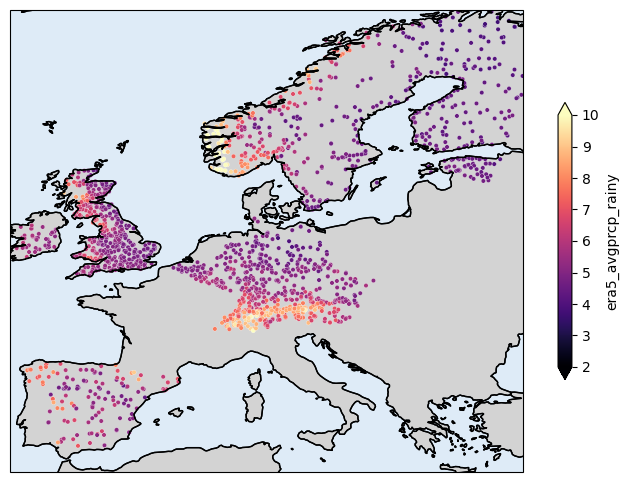

In [31]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_avgprcp_rainy'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =2, vmax=10, cmap_color='magma')

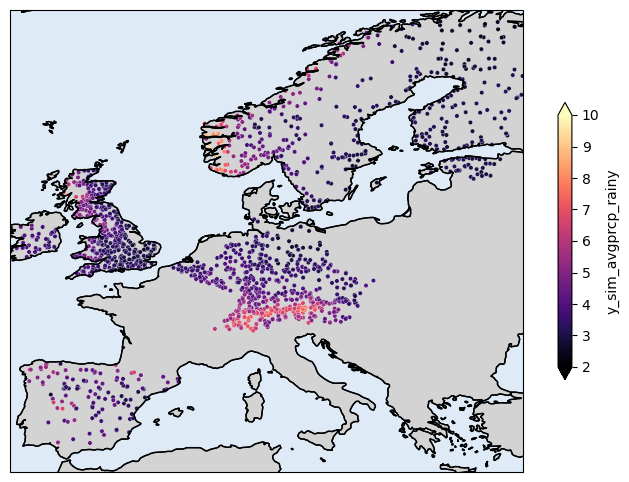

In [32]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_avgprcp_rainy'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =2, vmax=10, cmap_color='magma')

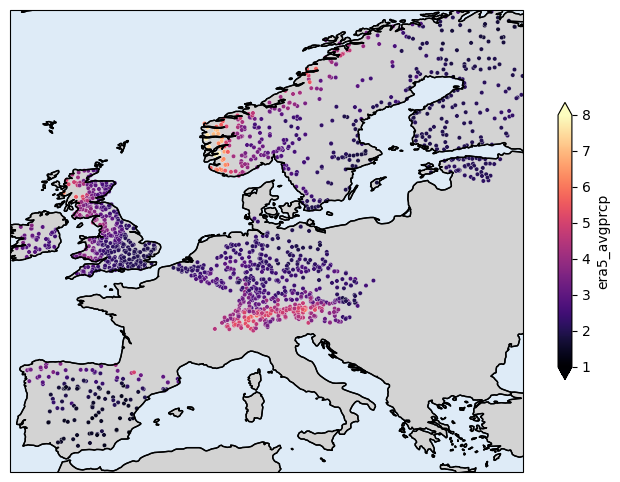

In [33]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_avgprcp'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =1, vmax=8, cmap_color='magma')

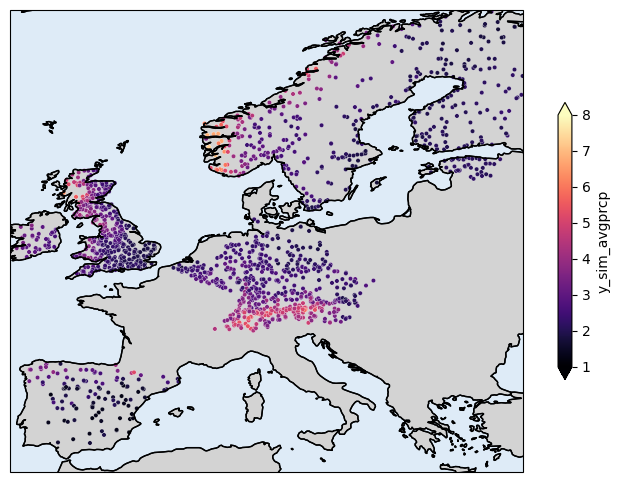

In [34]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_avgprcp'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =1, vmax=8, cmap_color='magma')

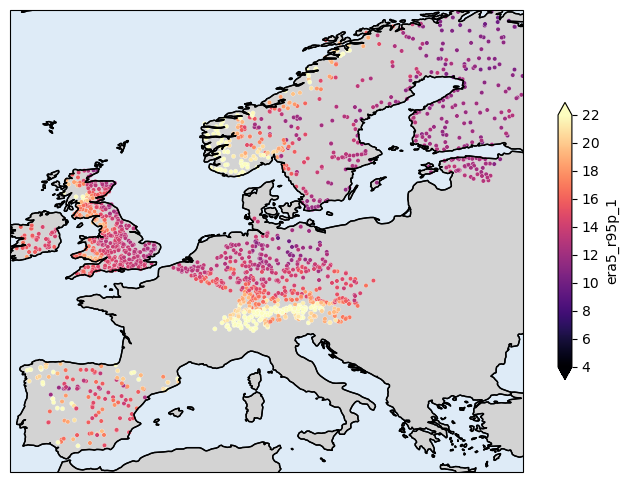

In [35]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_r95p_1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =4, vmax=22, cmap_color='magma')

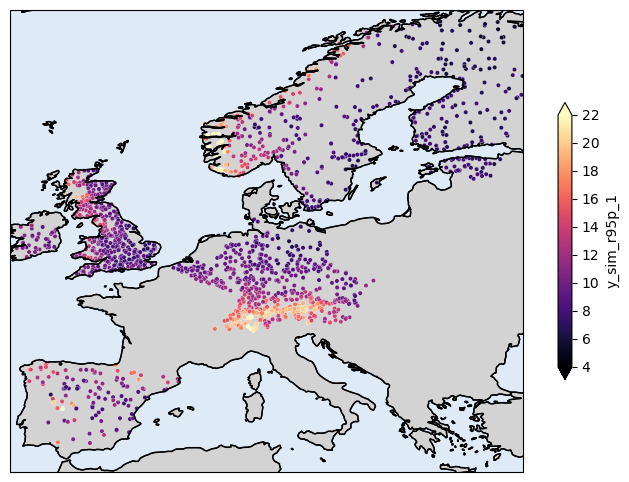

In [36]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_r95p_1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =4, vmax=22, cmap_color='magma')

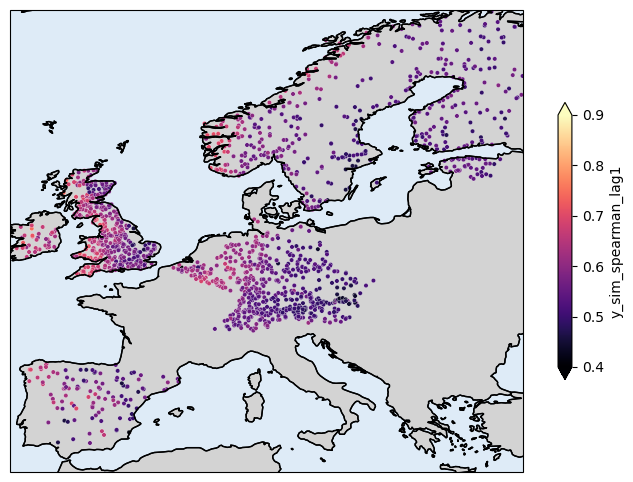

In [37]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_spearman_lag1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.4, vmax=0.9, cmap_color='magma')

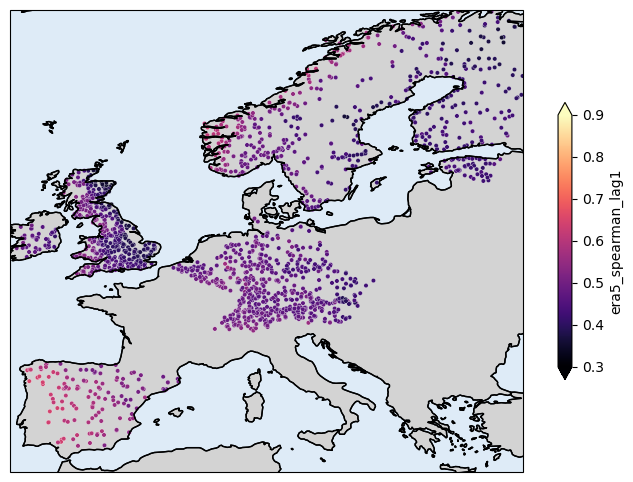

In [38]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_spearman_lag1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.3, vmax=0.9, cmap_color='magma')

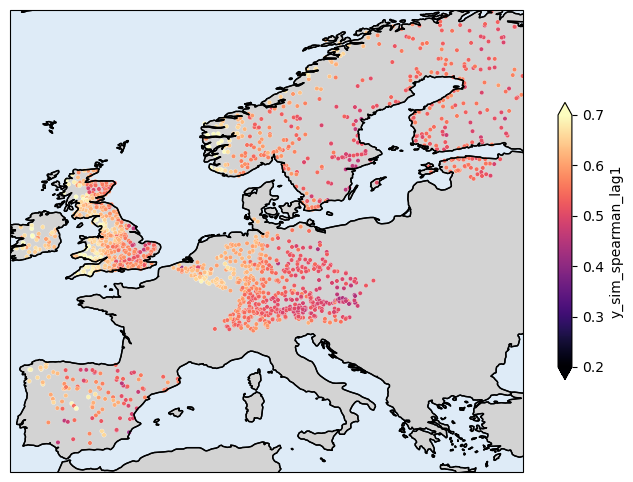

In [39]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'y_sim_spearman_lag1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.2, vmax=0.7, cmap_color='magma')

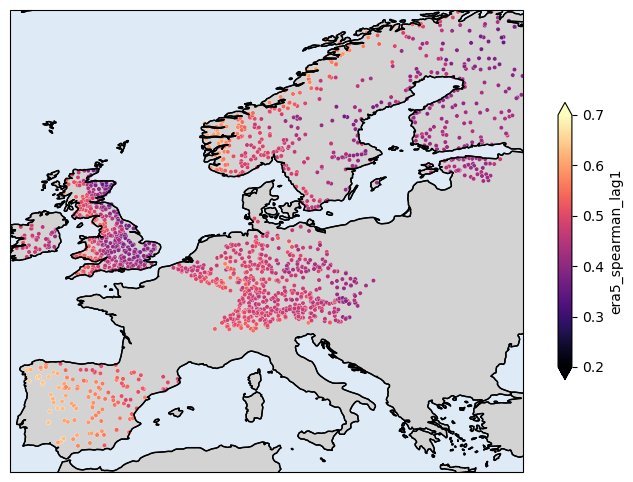

In [40]:
# Manually set the latitude and longitude extent
europe_extent = [-10, 30, 35, 70]
# Specify the index column to plot
index_column = 'era5_spearman_lag1'   # Replace 'NSE' with the name of your index column

# Plot the world map
plot_world_map(merged_df, index_column, europe_extent, vmin =0.2, vmax=0.7, cmap_color='magma')

Plotting using shapefiles

In [41]:
import geopandas as gpd

# Read the shapefiles
shapefile1 = gpd.read_file(r"S:\ashish\01_Analysis\01_Europe_Flood_Analysis\Caravan\Caravan\shapefiles\camelsgb\camelsgb_basin_shapes.shp")
shapefile2 = gpd.read_file(r"S:\ashish\01_Analysis\01_Europe_Flood_Analysis\GRDC_Caravan\GRDC-Caravan-extension-csv\shapefiles\grdc\grdc_basin_shapes.shp")

# Merge the shapefiles
merged = gpd.GeoDataFrame(pd.concat([shapefile1, shapefile2], ignore_index=True))

# Save to a GeoPackage
#merged.to_file("catchments.gpkg", layer='merged_layer', driver="GPKG")

In [42]:
# Ensure the 'gauge_id' column and 'index' column are in the correct type for merging
merged['gauge_id'] = merged['gauge_id'].astype(str)
merged_df['index'] = merged_df['index'].astype(str)

# Merge the GeoDataFrame with the DataFrame
merged = merged.merge(merged_df, left_on='gauge_id', right_on='index', how='left')

# Optionally, drop the 'index' column if it's no longer needed
merged = merged.drop(columns=['index'])

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch
from matplotlib.collections import PatchCollection

C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap

KeyboardInterrupt: 

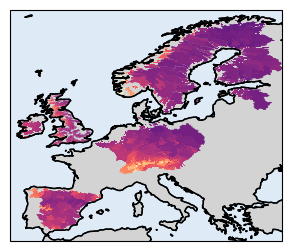

In [44]:
def plot_european_map_polygons_area(gdf, index_column, extent, cmap_color, vmin=None, vmax=None):
    # Clean the GeoDataFrame by dropping rows with missing values in the specified column
    gdf_cleaned = gdf.dropna(subset=[index_column])
    
    # Ensure the GeoDataFrame is in the correct CRS
    if gdf_cleaned.crs != "EPSG:4326":
        gdf_cleaned = gdf_cleaned.to_crs("EPSG:4326")
    
    # Calculate area and add it as a new column for sorting
    gdf_cleaned['area'] = gdf_cleaned.geometry.area
    
    # Sort the GeoDataFrame by area, smallest first
    gdf_cleaned = gdf_cleaned.sort_values(by='area',ascending=False)

    fig = plt.figure(figsize=(4.5, 3))
    # Change the projection to Lambert Conformal Conic for better representation of Europe
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.add_feature(cfeature.OCEAN, color='#deebf7')
    ax.add_feature(cfeature.COASTLINE)
    
    # Get the minimum and maximum values of the index column for custom colormap limits
    if vmin is None:
        vmin = gdf_cleaned[index_column].min()
    if vmax is None:
        vmax = gdf_cleaned[index_column].max()
    
    # Create a colormap and normalization
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_color)
    
    # Plot each polygon, smallest area last (on top)
    for idx, row in gdf_cleaned.iterrows():
        ax.add_geometries([row.geometry], crs=ccrs.PlateCarree(), 
                          facecolor=cmap(norm(row[index_column])), 
                          edgecolor='white', linewidth=0.0001)

    # Create a ScalarMappable and add the colorbar
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm._A = []  # Dummy array for the ScalarMappable
    
    #cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04,shrink=0.6, extend='both')
    #cbar.set_label(index_column)

    ax.coastlines()

    plt.savefig(index_column+'.jpeg',dpi=1200)
    plt.show()
    

# Assuming 'merged' is your merged GeoDataFrame and 'index_column' is the column you want to plot
index_column = 'era5_avgprcp_rainy'  # Replace with your actual column name
extent = [-11.5, 32, 35, 72]   # Define the extent for the European map (min_lon, max_lon, min_lat, max_lat)
cmap_color = 'magma'  # Choose a colormap

# Call the function to plot the map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=1, vmax=10)

C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap

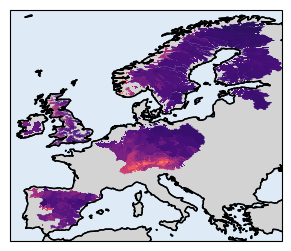

In [ ]:
# Specify the index column to plot
index_column = 'y_sim_avgprcp_rainy'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=1, vmax=10)

C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap

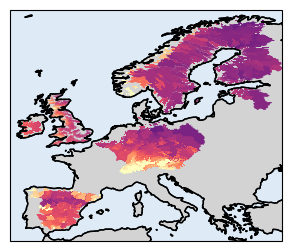

In [ ]:
# Specify the index column to plot
index_column = 'era5_r95p_1'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=4, vmax=22)

C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap

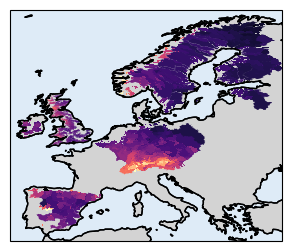

In [ ]:
index_column = 'y_sim_r95p_1'
# Plot the world map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=4, vmax=22)

C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap

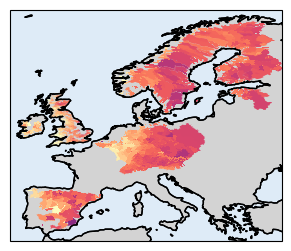

In [46]:
index_column = 'y_sim_spearman_lag1'
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=0.2, vmax=0.7)

C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\as2023\AppData\Local\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\as2023\AppData\Local\Temp\ipykernel_4784\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap

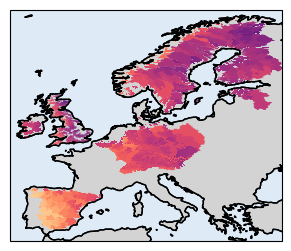

In [45]:
index_column = 'era5_spearman_lag1'
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=0.2, vmax=0.7)